In [1]:
# imports
import pymc as pm
import pytensor.tensor as pt
import numpy as np
from chronologer.calcurves import download_intcal20
from chronologer.calibration import calibrate, interpolate_calcurve, simulate_c14

In [2]:
# setup
# Example usage to create initial intcal20 dictionary
intcal20 = download_intcal20()

# recast calibration curve data as tensors for use in PyMC model context
calbp_tensor = pt.as_tensor_variable(intcal20['calbp'])
c14bp_tensor = pt.as_tensor_variable(intcal20['c14bp'])
c14_sigma_tensor = pt.as_tensor_variable(intcal20['c14_sigma'])

c:\users\carleton\documents\projects\chronologer\chronologer\chronologer\calcurves.py:19: UserWarning: Calibration curve data is not strictly increasing. Adjusting sign to correct...
  warnings.warn("Calibration curve data is not strictly increasing. Adjusting sign to correct...")


In [3]:
N = 50
calendar_ages = np.random.normal(-2500, 200, N)
radiocarbon_age = simulate_c14(calendar_ages, 
                               intcal20['calbp'], 
                               intcal20['c14bp'], 
                               intcal20['c14_sigma'])
radiocarbon_error = np.repeat(30, N)

In [ ]:
# Precompute calibration limits
cal_dates = calibrate(radiocarbon_ages = radiocarbon_age, 
                        radiocarbon_errors = radiocarbon_error, 
                        calbp = intcal20['calbp'], 
                        c14bp = intcal20['c14bp'], 
                        c14_sigma = intcal20['c14_sigma'], 
                        hdi_prob = 0.999999)

lower_bound = cal_dates['HDI Lower (BP)'].values
upper_bound = cal_dates['HDI Upper (BP)'].values

cal_dates

In [5]:
cal_upper_bound = max(intcal20['calbp'])
cal_lower_bound = min(intcal20['calbp'])
cal_upper_bound = max(upper_bound) * (1 - 0.3)
cal_lower_bound = min(lower_bound) * (1 + 0.3)

In [ ]:
print( (cal_lower_bound,cal_upper_bound) )

In [ ]:
# pymc
with pm.Model() as model:
    # Top-level Gaussian for true calendar dates
    tau_mu = pm.TruncatedNormal('tau_mu', 
                             mu=-2500, 
                             sigma=500, 
                             lower=cal_lower_bound, 
                             upper=cal_upper_bound)   
    tau_sd = pm.HalfNormal('tau_sd', sigma=400)   # Prior for standard deviation

    # Calendar dates (latent true dates)
    # Define a bounded normal distribution for each tau using precomputed 
    # calibration limits
    tau = pm.TruncatedNormal('tau', 
                             mu=tau_mu, 
                             sigma=tau_sd, 
                             lower=lower_bound, 
                             upper=upper_bound, 
                             shape=N)

    # calibration model
    mean, error = interpolate_calcurve(tau, 
                                       calbp_tensor, 
                                       c14bp_tensor, 
                                       c14_sigma_tensor)
    r_latent = pm.Normal('r_latent', 
                         mu=mean, 
                         sigma=error, 
                         shape=N)
    r_measured = pm.Normal('r_measured', 
                           mu=r_latent, 
                           sigma=radiocarbon_error, 
                           observed=radiocarbon_age,
                           shape=N)

    # Sample from the posterior
    step = pm.Metropolis()
    trace = pm.sample(draws=5000, step = step, chains = 3)

In [ ]:
pm.summary(trace)

In [ ]:
# plot the posterior densities for the top-level, process model parameters
pm.plot_posterior(trace, var_names=["tau_mu", "tau_sd"])

In [ ]:
# plot calibrated date posteriors
pm.plot_posterior(trace, var_names=["tau"])

In [26]:
# Mixture model parameters
n_components = 3  # Number of Gaussians in the mixture
weights_true = np.array([0.4, 0.4, 0.2])  # Weights for each Gaussian
means_true = np.array([-7500, -4000, -2000])  # Means of the Gaussian components
sds_true = np.array([100, 150, 50])  # Standard deviations of the components

# Number of data points
N = 100

# Simulate the component assignments
component_choices = np.random.choice(n_components, size=N, p=weights_true)

# Simulate the true calendar dates based on the component assignments
calendar_ages = np.array([np.random.normal(means_true[k], sds_true[k]) for k in component_choices])

# Simulate radiocarbon dates based on the true calendar dates (use your simulate_c14 function here)
radiocarbon_age = simulate_c14(calendar_ages, 
                               intcal20['calbp'], 
                               intcal20['c14bp'], 
                               intcal20['c14_sigma'])
radiocarbon_error = np.repeat(30, N)  # Assume constant lab error


In [27]:
# Precompute calibration limits
cal_dates = calibrate(radiocarbon_ages = radiocarbon_age, 
                        radiocarbon_errors = radiocarbon_error, 
                        calbp = intcal20['calbp'], 
                        c14bp = intcal20['c14bp'], 
                        c14_sigma = intcal20['c14_sigma'], 
                        hdi_prob = 0.999999)

lower_bound = cal_dates['HDI Lower (BP)'].values
upper_bound = cal_dates['HDI Upper (BP)'].values

cal_dates

,Radiocarbon Age,Mean Calibrated Age (BP),Std Dev (BP),HDI Lower (BP),HDI Upper (BP)
0,-6471.610414,-7370.938632,31.606691,-7560,-7175
1,-3688.254596,-4027.722059,52.702935,-4277,-3779
2,-3741.919025,-4090.818704,62.075757,-4404,-3853
3,-1957.632608,-1884.863503,45.558353,-2107,-1711
4,-3670.405849,-4007.061771,56.606019,-4235,-3731
...,...,...,...,...,...
95,-3651.275083,-3979.180160,58.938598,-4228,-3725
96,-3819.988924,-4215.319455,64.367529,-4428,-3971
97,-3739.888389,-4087.632453,61.708141,-4403,-3851
98,-1962.396302,-1890.679851,45.153034,-2110,-1712


In [28]:
cal_upper_bound = max(intcal20['calbp'])
cal_lower_bound = min(intcal20['calbp'])
cal_upper_bound = max(upper_bound) * (1 - 0.3)
cal_lower_bound = min(lower_bound) * (1 + 0.3)

In [29]:
with pm.Model() as model:
    # Mixture model weights
    weights = pm.Dirichlet("weights", a=np.ones(n_components))

    # Gaussian components for the mixture model
    means = pm.Uniform('means',
                       lower=cal_lower_bound,
                       upper=cal_upper_bound, 
                       shape=n_components)
    
    sds = pm.HalfNormal('sds', sigma=200, shape=n_components)

    # Define the component distributions
    components = [
        pm.TruncatedNormal.dist(mu=means[i], sigma=sds[i], lower=lower_bound, upper=upper_bound)
        for i in range(n_components)
    ]

    # Mixture model for tau
    tau = pm.Mixture("tau", w=weights, comp_dists=components, shape=N)

    # calibration model
    mean, error = interpolate_calcurve(tau, calbp_tensor, c14bp_tensor, c14_sigma_tensor)

    r_latent = pm.Normal('r_latent', mu=mean, sigma=error, shape=N)
    
    r_measured = pm.Normal('r_measured', mu=r_latent, sigma=radiocarbon_error, observed=radiocarbon_age)

    # Sample from the posterior
    step = pm.Metropolis()
    trace = pm.sample(draws=5000, tune=5000, step=step, chains=3)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>Metropolis: [weights]
>Metropolis: [means]
>Metropolis: [sds]
>Metropolis: [tau]
>Metropolis: [r_latent]


Output()

Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 5737 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [30]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],-4183.588,1477.807,-7000.930,-1241.868,135.956,169.231,773.0,32.0,1.11
means[1],-4710.983,2217.969,-8833.206,-1198.722,157.632,177.578,1597.0,2057.0,1.09
means[2],-4993.103,2480.118,-9173.720,-1199.032,58.631,41.465,1698.0,2640.0,1.00
r_latent[0],-6454.659,22.435,-6494.497,-6412.507,1.012,0.718,697.0,311.0,1.00
r_latent[1],-3690.494,28.170,-3743.883,-3635.766,1.449,1.026,378.0,788.0,1.00
...,...,...,...,...,...,...,...,...,...
tau[98],-1893.133,44.193,-1981.880,-1828.705,2.750,1.947,268.0,188.0,1.01
tau[99],-7338.678,50.762,-7418.945,-7268.713,2.445,1.730,453.0,475.0,1.00
weights[0],0.739,0.405,0.002,0.995,0.207,0.159,7.0,28.0,1.36
weights[1],0.243,0.404,0.000,0.986,0.206,0.159,7.0,29.0,1.35


array([[<Axes: title={'center': 'means\n0'}>,
        <Axes: title={'center': 'means\n1'}>,
        <Axes: title={'center': 'means\n2'}>],
       [<Axes: title={'center': 'sds\n0'}>,
        <Axes: title={'center': 'sds\n1'}>,
        <Axes: title={'center': 'sds\n2'}>],
       [<Axes: title={'center': 'weights\n0'}>,
        <Axes: title={'center': 'weights\n1'}>,
        <Axes: title={'center': 'weights\n2'}>]], dtype=object)

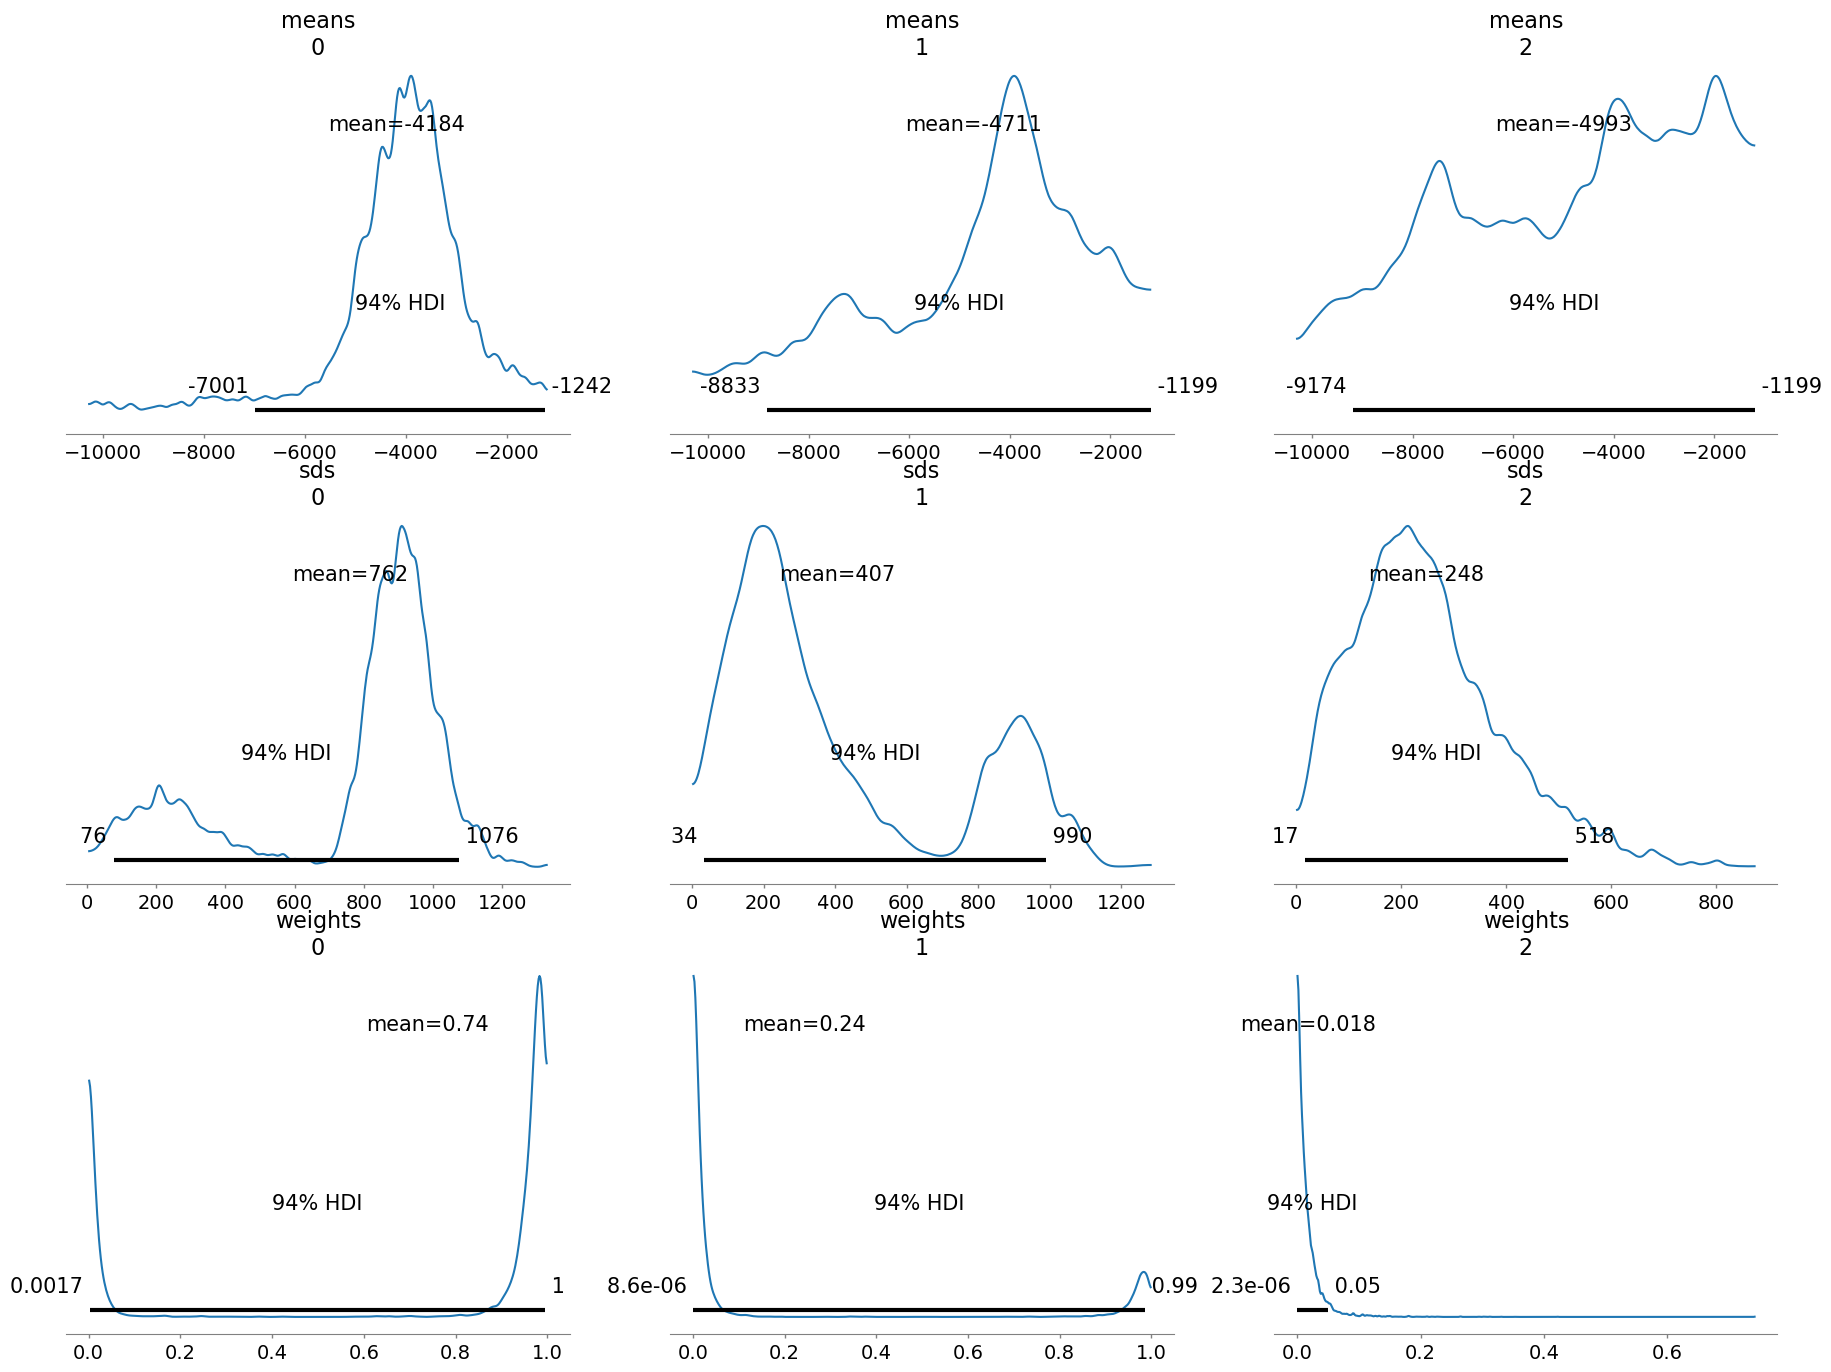

In [31]:
# plot the posterior densities for the top-level, process model parameters
pm.plot_posterior(trace, var_names=["means", "sds", "weights"])